copy of [this site](https://github.com/orico/ActiveLearningFrameworkTutorial)

We start with all the needed dependencies.

## **Active Learning Tutorial**

These days we are exposed to an abundance of unlabeled data either from the Internet or from some other source such as academia or business worlds. Due to the fact that unlabeled data is relatively easy to acquire and is expensive to label, companies usually employ an expert or several employees whose purpose is to label data [1]. Consider the following situation, a data-driven medical company has a lot of MRI scans and they need to employ an expert that will help them interpret these scans. The company has limited resources and they cant interpret or label all of their data; this is the point where they decide to use active-learning (AL). The promise of AL is that by iteratively increasing the size of our carefully selected labeled data, it is possible to achieve similar (or greater [2]) performance to using a fully supervised data-set with a fraction of the cost or time that it takes to label all the data. AL is considered to be a semi-supervised method, between unsupervised and fully supervised in terms of the amount of labeled data, i.e., for unsupervised data we use 0% labeled samples and for fully supervised we use 100% labeled samples. Therefore, the decision of how much data to use or alternatively how much performance is required from the model relies on a resource management decision, in other words it can be a business decision. 

There are three scenarios for AL: 
1. Membership query synthesis, i.e., a generated sample is sent to an oracle for labeling.
2. Stream-Based selective sampling, i.e, each sample is considered separately - in our case for lable-querying or rejection. Similarly to online-learning, the data is not saved, there are no assumptions on data distribution, and therefore it is adaptive to change. 
3. Pool-Based sampling, i.e., sampled are chosen from a pool of unlabeled data for the purpose of labeling [3]. 
In this tutorial we use the third scenario.

The following pseudo algorithm represents the learning process, as written in the code, for pool-based sampling:
1. Divide the data to a 'pool' and a test-set
2. Select 'k' samples from the pool for the initial train-set and label them, the remaining data will be the validation-set
3. Normalize all the sets
4. Train the Model using the train-set, with balanced weights.
5. Use the trained model with the validation-set, get probabilities per sample.
6. Use the trained model with the test-set, get performance measures.
7. Select 'k' most-informative samples based on per-sample-probabilities, i.e., those that the model was most uncertain about regarding their labelling.
8. Move these 'k' samples from the validation set to the train-set and query their labels.
9. Inverse normalization for all the data-sets
10. Stop according to the stop criterion, otherwise go to 3. 

There are a few things to note before going forward: 
1. The fully-supervised performance of a chosen algorithm is usually the upper bound, therefore it is advisable to try several algorithms.
2. Normalization for all sets must be inversed and normalized again after we remove samples from the validation set, because our sample distribution changed in both the new validation and new train-sets.
2. The sample selection function relies on test-sample probabilities derived from the trained model, therefore we can only use algorithms that provide access to sample probabilities.
3. 'k' is a hyper parameter

Our most important tool in AL method is the sample selection function, this is the only point where we influence the learning process and it crucial to use the right method. This area is a hot research topic and there are many studies that propose competing selection functions. 
In this tutorial I propose four known selection functions:
1. Random selection - we select 'k' random samples from the validation set.
2. Entropy selection - we select 'k' samples with the highest entropy, i.e., with high uncertainty.
3. Margin selection - we select 'k' samples with the lowest difference between the two highest class probabilities, i.e., a higher figure will be given for samples whose model was very certain about a single class and lower to samples whose class probabilities are very similar. 

The code provided [here](https://github.com/orico/ActiveLearningFrameworkTutorial) utilizes a modular architecture in terms of selecting various learning algorithms and selection functions and can be used as a base for other model-function comparisons.

We compare several learning algorithms, such as support vector machine (SVM) with a linear kernel, random forest (RF) and logistic regression (LOG). Each algorithm was executed with all of the selection functions using all 'k' = [10,25,50,125,250], accumulating a total of 80 experiments. Due to the random nature of some of the algorithms and the selection functions, it is advisable to run repeated experiments in the code in order to calculate a statistical significant result. However, running times are long and I have chosen to run the experiment only once for each combination of (model,function,k).

The following is an explanation of the code and its class architecture.


In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import os
import time
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats
from pylab import rcParams
from sklearn.utils import check_random_state
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, \
    GradientBoostingClassifier

max_queried = 500

We start by downloading our data and splitting it to train and test, according to known MNIST definitions 60K/10K split. later the train-set will be split to train and validation.


In [ ]:
trainset_size = 60000  # ie., testset_size = 10000

def download():
    mnist = fetch_openml('mnist_784') # 包含data，target数据
    X = mnist.data.astype('float64') # 转换格式
    y = mnist.target
    print ('MNIST:', X.shape, y.shape)
    return (X, y)


def split(train_size):
    X_train_full = X[:train_size]
    y_train_full = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    return (X_train_full, y_train_full, X_test, y_test) # 本身就是tuple形式，加括号只是为了更加清晰

We create a modular class representation, 'BaseModel' is a base model for the class architecture, you can implement new models and use them interchangeably or in addition to all other models.
our current implementations include SVM, logistic regression, random forest and gradient boosting.

In [ ]:
class BaseModel(object): # 用于使模型的结构清晰统一

    def __init__(self):
        pass

    def fit_predict(self):
        pass


class SvmModel(BaseModel):

    model_type = 'Support Vector Machine with linear Kernel'
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training svm...')
        self.classifier = SVC(C=1, kernel='linear', probability=True,
                              class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)


class LogModel(BaseModel):

    model_type = 'Multinominal Logistic Regression' 
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training multinomial logistic regression')
        train_samples = X_train.shape[0]
        self.classifier = LogisticRegression(
            C=50. / train_samples,
            multi_class='multinomial',
            penalty='l1',
            solver='saga',
            tol=0.1,
            class_weight=c_weight,
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)

class RfModel(BaseModel):

    model_type = 'Random Forest'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training random forest...')
        self.classifier = RandomForestClassifier(n_estimators=500, class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)
   

Our 'TrainModel' class accepts one of the previously in defined learning algorithms, trains using the training set and gets performance measurements from the test set.

In [ ]:
class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    # we train normally and get probabilities for the validation set. i.e., we use the probabilities to select the most uncertain samples

    def train(self, X_train, y_train, X_val, X_test, c_weight):
        print ('Train set:', X_train.shape, 'y:', y_train.shape)
        print ('Val   set:', X_val.shape)
        print ('Test  set:', X_test.shape)
        t0 = time.time()
        (X_train, X_val, X_test, self.val_y_predicted,
         self.test_y_predicted) = \
            self.model_object.fit_predict(X_train, y_train, X_val, X_test, c_weight)
        self.run_time = time.time() - t0
        return (X_train, X_val, X_test)  # we return them in case we use PCA, with all the other algorithms, this is not needed.

    # we want accuracy only for the test set

    def get_test_accuracy(self, i, y_test): 
        # 这里的classification_report()和confusion_matrix()没太清楚作用
        classif_rate = np.mean(self.test_y_predicted.ravel() == y_test.ravel()) * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:',i)
        print('--------------------------------')
        print('y-test set:',y_test.shape)
        print('Example run in %.3f s' % self.run_time,'\n')
        print("Accuracy rate for %f " % (classif_rate))    
        print("Classification report for classifier %s:\n%s\n" % (self.model_object.classifier, metrics.classification_report(y_test, self.test_y_predicted)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, self.test_y_predicted))
        print('--------------------------------')


We create a modular selection function class representation, 'BaseSelectionFunction' is a base class for various sample selection methods. Using this architecture, you can implement new selection methods and use them in addition or instead of previous methods, for experimental purposes. Our current implementations include random-selection, entropy-selection, margin sampling-selection and minimum standard deviation-selection.

In [ ]:
class BaseSelectionFunction(object):

    def __init__(self):
        pass

    def select(self):
        pass

# 这里的probas_val是什么?是每个样本在每个类的概率形成的矩阵么?
class RandomSelection(BaseSelectionFunction):
#随机无重复挑选
    @staticmethod
    def select(probas_val, initial_labeled_samples):
        random_state = check_random_state(0)
        selection = np.random.choice(probas_val.shape[0], initial_labeled_samples, replace=False)

#     print('uniques chosen:',np.unique(selection).shape[0],'<= should be equal to:',initial_labeled_samples)

        return selection


class EntropySelection(BaseSelectionFunction):
#熵最优挑选,熵是某种状态的信息量,或者某个变量的信息量
    @staticmethod
    def select(probas_val, initial_labeled_samples):
        e = (-probas_val * np.log2(probas_val)).sum(axis=1)
        selection = (np.argsort(e)[::-1])[:initial_labeled_samples]
        return selection
      
      
class MarginSamplingSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        rev = np.sort(probas_val, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        selection = np.argsort(values)[:initial_labeled_samples]
        return selection


We have a class that is used to normalize using a MinMax Scaler in the range of [0,1].

In [ ]:
class Normalize(object):
    
    def normalize(self, X_train, X_val, X_test):
        self.scaler = MinMaxScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_val, X_test) 
    
    def inverse(self, X_train, X_val, X_test):
        # 这是如何做到inverse的呢? 
        X_train = self.scaler.inverse_transform(X_train)
        X_val   = self.scaler.inverse_transform(X_val)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_val, X_test) 

Initially we would like to get a random sampling from the unlabeled data-pool, this is done using random.choice without replacement.

In [ ]:
def get_k_random_samples(initial_labeled_samples, X_train_full,
                         y_train_full):
    random_state = check_random_state(0)
    permutation = np.random.choice(trainset_size,
                                   initial_labeled_samples,
                                   replace=False)
    print ()
    print ('initial random chosen samples', permutation.shape),
#            permutation)
    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    X_train = X_train.reshape((X_train.shape[0], -1))
    bin_count = np.bincount(y_train.astype('int64')) # what bincount and unique do? and it is necessary?
    unique = np.unique(y_train.astype('int64'))
    print (
        'initial train set:',
        X_train.shape,
        y_train.shape,
        'unique(labels):',
        bin_count,
        unique,
        )
    return (permutation, X_train, y_train)

This is the main class that initiates the active-learning process according to the algorithm described in the introduction. In short, we select 'k' random samples, train a model, select the most informative samples, remove from the validation set, query their labels and retrain using those samples until reaching the stop criteria.

In [ ]:
class TheAlgorithm(object):

    accuracies = []
# 第一次打标签数量、模型、样本挑选方式
    def __init__(self, initial_labeled_samples, model_object, selection_function):
        self.initial_labeled_samples = initial_labeled_samples
        self.model_object = model_object
        self.sample_selection_function = selection_function

    def run(self, X_train_full, y_train_full, X_test, y_test):

        # initialize process by applying base learner to labeled training data set to obtain Classifier

        (permutation, X_train, y_train) = \
            get_k_random_samples(self.initial_labeled_samples,
                                 X_train_full, y_train_full)
        self.queried = self.initial_labeled_samples # 每次打标签数量和初始打标签数量相同
        self.samplecount = [self.initial_labeled_samples] # 这里只是下标还是直接就是样本？

        # permutation, X_train, y_train = get_equally_k_random_samples(self.initial_labeled_samples,classes)

        # assign the val set the rest of the 'unlabelled' training data

        X_val = np.array([])
        y_val = np.array([])
        X_val = np.copy(X_train_full) #　为什么创建一个空数组，而非直接赋值呢？
        X_val = np.delete(X_val, permutation, axis=0)# 0表示按照列删除,那样本就是一列一个的格式了.
        y_val = np.copy(y_train_full)
        y_val = np.delete(y_val, permutation, axis=0)
        print ('val set:', X_val.shape, y_val.shape, permutation.shape)
        print ()

        # normalize data

        normalizer = Normalize()
        X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)   
        
        self.clf_model = TrainModel(self.model_object)
        (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
        active_iteration = 1
        self.clf_model.get_test_accuracy(1, y_test)

        # fpfn = self.clf_model.test_y_predicted.ravel() != y_val.ravel()
        # print(fpfn)
        # self.fpfncount = []
        # self.fpfncount.append(fpfn.sum() / y_test.shape[0] * 100)

        while self.queried < max_queried:# 设置了最大查询数量为500

            active_iteration += 1

            # get validation probabilities

            probas_val = self.clf_model.model_object.classifier.predict_proba(X_val)
            print ('val predicted:',
                   self.clf_model.val_y_predicted.shape,
                   self.clf_model.val_y_predicted)
            print ('probabilities:', probas_val.shape, '\n',
                   np.argmax(probas_val, axis=1))

            # select samples using a selection function

            uncertain_samples = \
                self.sample_selection_function.select(probas_val, self.initial_labeled_samples)

            # normalization needs to be inversed and recalculated based on the new train and test set.
 
            X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   

            # get the uncertain samples from the validation set
            # 训练集变化的信息
            print ('trainset before', X_train.shape, y_train.shape)
            X_train = np.concatenate((X_train, X_val[uncertain_samples]))
            y_train = np.concatenate((y_train, y_val[uncertain_samples]))
            print ('trainset after', X_train.shape, y_train.shape)
            self.samplecount.append(X_train.shape[0])

            bin_count = np.bincount(y_train.astype('int64'))
            unique = np.unique(y_train.astype('int64'))
            print (
                'updated train set:',
                X_train.shape,
                y_train.shape,
                'unique(labels):',
                bin_count,
                unique,
                )

            X_val = np.delete(X_val, uncertain_samples, axis=0)
            y_val = np.delete(y_val, uncertain_samples, axis=0)
            print ('val set:', X_val.shape, y_val.shape)# 验证集信息
            print ()

            # normalize again after creating the 'new' train/test sets
            normalizer = Normalize()
            X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)               

            self.queried += self.initial_labeled_samples
            (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
            self.clf_model.get_test_accuracy(active_iteration, y_test)

        print ('final active learning accuracies',
               self.clf_model.accuracies)





We download the data, split to train validation and test, we run the experiment by iterating over all of our training algorithms X all of our selection functions X all possible k's in the range of [10,25,50,125,250]. The accuracy results are kept in a dictionary and pickle-saved to a unique file as soon as the model finishes training - this is crucial when using google colaboratory as it tends to disconnect from time to time. We also limit our training to a maximum of 500 queried samples.

In [ ]:
(X, y) = download()
(X_train_full, y_train_full, X_test, y_test) = split(trainset_size)
print ('train:', X_train_full.shape, y_train_full.shape)
print ('test :', X_test.shape, y_test.shape)
classes = len(np.unique(y))
print ('unique classes', classes)

def pickle_save(fname, data):
  filehandler = open(fname,"wb")
  pickle.dump(data,filehandler)
  filehandler.close() 
  print('saved', fname, os.getcwd(), os.listdir())

def pickle_load(fname):
  print(os.getcwd(), os.listdir())
  file = open(fname,'rb')
  data = pickle.load(file)
  file.close()
  print(data)
  return data
  
def experiment(d, models, selection_functions, Ks, repeats, contfrom):
    algos_temp = []
    print ('stopping at:', max_queried)
    count = 0
    for model_object in models:
      if model_object.__name__ not in d:
          d[model_object.__name__] = {}
      
      for selection_function in selection_functions:
        if selection_function.__name__ not in d[model_object.__name__]:
            d[model_object.__name__][selection_function.__name__] = {}
        
        for k in Ks:
            d[model_object.__name__][selection_function.__name__][str(k)] = []           
            
            for i in range(0, repeats):
                count+=1
                if count >= contfrom:
                    print ('Count = %s, using model = %s, selection_function = %s, k = %s, iteration = %s.' % (count, model_object.__name__, selection_function.__name__, k, i))
                    alg = TheAlgorithm(k, 
                                       model_object, 
                                       selection_function
                                       )
                    alg.run(X_train_full, y_train_full, X_test, y_test)
                    d[model_object.__name__][selection_function.__name__][str(k)].append(alg.clf_model.accuracies)
                    fname = 'Active-learning-experiment-' + str(count) + '.pkl'
                    pickle_save(fname, d)
                    if count % 5 == 0:
                        print(json.dumps(d, indent=2, sort_keys=True))
                    print ()
                    print ('---------------------------- FINISHED ---------------------------')
                    print ()
    return d


max_queried = 500 

repeats = 1

models = [SvmModel, RfModel, LogModel] 

selection_functions = [RandomSelection, MarginSamplingSelection, EntropySelection] 

Ks = [250,125,50,25,10] 

d = {}
stopped_at = -1 

# print('directory dump including pickle files:', os.getcwd(), np.sort(os.listdir()))  
# d = pickle_load('Active-learning-experiment-' + str(stopped_at) + '.pkl')  
# print(json.dumps(d, indent=2, sort_keys=True))

d = experiment(d, models, selection_functions, Ks, repeats, stopped_at+1)
print (d)
results = json.loads(json.dumps(d, indent=2, sort_keys=True))
print(results)


MNIST: (70000, 784) (70000,)
train: (60000, 784) (60000,)
test : (10000, 784) (10000,)
unique classes 10
stopping at: 500
Count = 1, using model = SvmModel, selection_function = RandomSelection, k = 250, iteration = 0.

initial random chosen samples (250,)
initial train set: (250, 784) (250,) unique(labels): [18 22 24 33 17 20 32 26 28 30] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 18.731 s 

Accuracy rate for 84.690000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   suppor

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix:
[[ 481    3    1  440    0    0    9    2   24   20]
 [   0 1122    4    2    0    0    1    0    6    0]
 [  22  147  489  245    0    0   17   20   75   17]
 [   0   99   35  821    0    1    4    7   13   30]
 [  15   99    1  164    0    0    2    8    6  687]
 [  22  132    1  406    0  109    9   13   76  124]
 [ 231  114   95  194    0    0  157    8    8  151]
 [  14  140   23   24    0    0    0  724    6   97]
 [  30  234  111  188    0    5    1   13  205  187]
 [  21   82    2   55    0    0    0   51    2  796]]
--------------------------------
val predicted: (59975,) ['3' '0' '3' ... '9' '6' '8']
probabilities: (59975, 9) 
 [3 0 8 ... 8 3 3]
trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [4 6 3 9 1 4 6 7 3 7] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
I

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.26      0.84      0.40       980
           1       0.40      0.99      0.57      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.34      0.70      0.46      1028
           8       0.29      0.52      0.37       974
           9       0.56      0.12      0.20      1009

    accuracy                           0.33     10000
   macro avg       0.19      0.32      0.20     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.41      0.72      0.52       980
           1       0.50      0.99      0.67      1135
           2       0.00      0.00      0.00      1032
           3       0.30      0.43      0.35      1010
           4       0.34      0.74      0.46       982
           5       0.36      0.02      0.04       892
           6       0.00      0.00      0.00       958
           7       0.51      0.77      0.61      1028
           8       0.53      0.40      0.46       974
           9       0.86      0.06      0.11      1009

    accuracy                           0.43     10000
   macro avg       0.38      0.41      0.32     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix:
[[ 876    7    0   34    7    4   33    3   14    2]
 [   1 1105    0    3    0    0   10    2   14    0]
 [ 152  115    0   67   18    0  260   71  291   58]
 [ 127   76    0  425   42    0   29   35  261   15]
 [  44   35    0   10  615   12   15   84  145   22]
 [ 162   77    0  139   89  158   20   56  172   19]
 [ 246   23    0    4   78    0  575    2   29    1]
 [   3   60    0    6   41   10    0  828   13   67]
 [  52   46    0   77   29    3   17   32  712    6]
 [  22   24    0   36  125   13    1  446  278   64]]
--------------------------------
val predicted: (59970,) ['3' '0' '9' ... '7' '6' '8']
probabilities: (59970, 9) 
 [2 2 5 ... 6 3 3]
trainset before (30, 784) (30,)
trainset after (40, 784) (40,)
updated train set: (40, 784) (40,) unique(labels): [ 3 10  1  4  3  3  4  6  4  2] [0 1 2 3 4 5 6 7 8 9]
val set: (59960, 784) (59960,)

Train set: (40, 784) y: (40,)
Val   set: (59960, 784)
Test  set: (10000, 784)
training svm...
------------------------

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.85      0.73      0.79       980
           1       0.90      0.44      0.59      1135
           2       0.31      0.87      0.46      1032
           3       0.63      0.34      0.44      1010
           4       0.79      0.23      0.35       982
           5       0.49      0.42      0.45       892
           6       0.49      0.63      0.55       958
           7       0.44      0.85      0.58      1028
           8       0.00      0.00      0.00       974
           9       0.36      0.34      0.35      1009

    accuracy                           0.49     10000
   macro avg       0.53      0.48      0.46     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.37      0.10      0.15      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.64      0.58      0.61       958
           7       0.27      0.53      0.36      1028
           8       0.16      0.77      0.27       974
           9       0.20      0.43      0.28      1009

    accuracy                           0.24     10000
   macro avg       0.16      0.24      0.17     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.47      0.47      0.47      1135
           2       0.95      0.10      0.19      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.55      0.40      0.46       892
           6       0.42      0.91      0.58       958
           7       0.37      0.44      0.40      1028
           8       0.21      0.80      0.34       974
           9       0.30      0.34      0.32      1009

    accuracy                           0.34     10000
   macro avg       0.33      0.35      0.28     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.82      0.62      0.70       980
           1       0.74      0.93      0.83      1135
           2       0.90      0.15      0.26      1032
           3       0.59      0.59      0.59      1010
           4       0.47      0.64      0.54       982
           5       0.00      0.00      0.00       892
           6       0.81      0.68      0.74       958
           7       0.40      0.63      0.49      1028
           8       0.26      0.33      0.29       974
           9       0.34      0.56      0.42      1009

    accuracy                           0.52     10000
   macro avg       0.53      0.51      0.49     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.16      0.81      0.26       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.78      0.18      0.29       982
           5       0.23      0.06      0.09       892
           6       0.40      0.75      0.52       958
           7       0.00      0.00      0.00      1028
           8       0.23      0.57      0.32       974
           9       0.19      0.05      0.08      1009

    accuracy                           0.23     10000
   macro avg       0.20      0.24      0.16     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.47      0.68      0.56       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.76      0.20      0.32       982
           5       0.11      0.40      0.17       892
           6       0.41      0.77      0.54       958
           7       0.00      0.00      0.00      1028
           8       0.20      0.64      0.31       974
           9       0.21      0.07      0.10      1009

    accuracy                           0.27     10000
   macro avg       0.22      0.28      0.20     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.80      0.28      0.42       982
           5       0.12      0.97      0.21       892
           6       0.67      0.69      0.68       958
           7       0.00      0.00      0.00      1028
           8       0.59      0.17      0.26       974
           9       0.29      0.06      0.10      1009

    accuracy                           0.28     10000
   macro avg       0.33      0.29      0.25     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix:
[[ 747    0    0    0    0  213   16    0    1    3]
 [   0    0    0    0    0 1105    3    0   26    1]
 [  76    0    0    0    8  540  333    0   18   57]
 [   2    0    0    0    0  981    3    0    9   15]
 [   5    0    0    0  274  517  136    0    6   44]
 [   2    0    0    0    1  858   10    0   12    9]
 [  10    0    0    0    7  210  728    0    1    2]
 [  12    0    0    0    2  983   13    0   13    5]
 [   3    0    0    0    0  776   15    0  163   17]
 [  26    0    0    0   52  805   47    0   17   62]]
--------------------------------
val predicted: (59960,) ['5' '0' '4' ... '5' '6' '5']
probabilities: (59960, 6) 
 [2 0 2 ... 2 2 2]
trainset before (40, 784) (40,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [12  0 10  0  1 11 13  0  2  1] [0 2 4 5 6 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training svm...
------------------------------

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       980
           1       0.00      0.00      0.00      1135
           2       0.82      0.42      0.55      1032
           3       0.00      0.00      0.00      1010
           4       0.82      0.29      0.43       982
           5       0.12      0.97      0.22       892
           6       0.70      0.76      0.73       958
           7       0.00      0.00      0.00      1028
           8       0.64      0.16      0.26       974
           9       0.78      0.05      0.09      1009

    accuracy                           0.33     10000
   macro avg       0.48      0.34      0.31     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       980
           1       0.00      0.00      0.00      1135
           2       0.96      0.36      0.52      1032
           3       0.00      0.00      0.00      1010
           4       0.98      0.18      0.31       982
           5       0.14      0.94      0.25       892
           6       0.62      0.70      0.66       958
           7       0.00      0.00      0.00      1028
           8       0.66      0.20      0.31       974
           9       0.30      0.35      0.32      1009

    accuracy                           0.34     10000
   macro avg       0.44      0.36      0.32     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       980
           1       0.40      0.00      0.00      1135
           2       0.86      0.47      0.61      1032
           3       0.00      0.00      0.00      1010
           4       0.98      0.18      0.31       982
           5       0.15      0.92      0.26       892
           6       0.71      0.69      0.70       958
           7       0.00      0.00      0.00      1028
           8       0.51      0.45      0.48       974
           9       0.32      0.34      0.33      1009

    accuracy                           0.38     10000
   macro avg       0.47      0.39      0.35     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       980
           1       0.40      0.00      0.00      1135
           2       0.67      0.36      0.47      1032
           3       0.00      0.00      0.00      1010
           4       0.81      0.33      0.47       982
           5       0.16      0.89      0.27       892
           6       0.51      0.86      0.64       958
           7       0.00      0.00      0.00      1028
           8       0.55      0.43      0.48       974
           9       0.34      0.26      0.30      1009

    accuracy                           0.38     10000
   macro avg       0.43      0.39      0.35     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix:
[[786   0   1   0   0 102  84   0   1   6]
 [  0   2   1   0   0 997  10   0 125   0]
 [ 47   0 368   0  10 168 329   0  94  16]
 [ 30   0  10   0   0 901  19   0  45   5]
 [  0   0  15   0 461 271 117   0  10 108]
 [ 11   0   6   0   6 792  53   0  17   7]
 [ 11   0   3   0   3 110 827   0   3   1]
 [  8   0  77   0  40 516  31   0  33 323]
 [ 19   3  25   0   7 433  64   0 415   8]
 [ 12   0  29   0 207 511  34   0  17 199]]
--------------------------------
val predicted: (59910,) ['5' '0' '4' ... '5' '6' '5']
probabilities: (59910, 8) 
 [4 0 3 ... 4 5 6]
trainset before (90, 784) (90,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [15  1 12  0 13 11 23  3 14  8] [0 1 2 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 7.21

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       980
           1       0.40      0.00      0.00      1135
           2       0.81      0.38      0.52      1032
           3       0.00      0.00      0.00      1010
           4       0.61      0.40      0.48       982
           5       0.18      0.86      0.30       892
           6       0.49      0.88      0.63       958
           7       0.96      0.09      0.16      1028
           8       0.41      0.52      0.46       974
           9       0.37      0.28      0.32      1009

    accuracy                           0.40     10000
   macro avg       0.51      0.42      0.37     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       980
           1       0.33      0.00      0.00      1135
           2       0.86      0.38      0.52      1032
           3       0.00      0.00      0.00      1010
           4       0.68      0.39      0.49       982
           5       0.20      0.86      0.33       892
           6       0.51      0.87      0.65       958
           7       0.94      0.66      0.78      1028
           8       0.42      0.52      0.46       974
           9       0.44      0.32      0.37      1009

    accuracy                           0.47     10000
   macro avg       0.53      0.48      0.45     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       980
           1       0.27      0.02      0.04      1135
           2       0.78      0.42      0.54      1032
           3       0.00      0.00      0.00      1010
           4       0.63      0.30      0.41       982
           5       0.18      0.86      0.30       892
           6       0.52      0.88      0.65       958
           7       0.96      0.58      0.73      1028
           8       0.46      0.48      0.47       974
           9       0.51      0.20      0.29      1009

    accuracy                           0.45     10000
   macro avg       0.52      0.46      0.43     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       980
           1       0.28      0.02      0.04      1135
           2       0.80      0.41      0.55      1032
           3       0.00      0.00      0.00      1010
           4       0.72      0.24      0.36       982
           5       0.19      0.86      0.31       892
           6       0.54      0.88      0.67       958
           7       0.74      0.65      0.69      1028
           8       0.47      0.48      0.48       974
           9       0.41      0.22      0.29      1009

    accuracy                           0.45     10000
   macro avg       0.50      0.46      0.42     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       980
           1       0.28      0.02      0.04      1135
           2       0.85      0.42      0.56      1032
           3       0.00      0.00      0.00      1010
           4       0.69      0.55      0.61       982
           5       0.20      0.86      0.32       892
           6       0.58      0.88      0.70       958
           7       0.82      0.67      0.74      1028
           8       0.54      0.47      0.50       974
           9       0.55      0.33      0.41      1009

    accuracy                           0.49     10000
   macro avg       0.54      0.50      0.47     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.86      0.58      0.70       980
           1       0.63      0.91      0.75      1135
           2       0.39      0.28      0.33      1032
           3       0.37      0.63      0.46      1010
           4       0.28      0.49      0.36       982
           5       0.26      0.01      0.02       892
           6       0.37      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.63      0.47      0.53       980
           1       0.60      0.92      0.73      1135
           2       0.71      0.40      0.51      1032
           3       0.37      0.11      0.17      1010
           4       0.00      0.00      0.00       982
           5       0.18      0.04      0.06       892
           6       0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
           4       0.69      0.38      0.49       982
           5       0.65      0.42      0.51       892
           6       0.95      0.32      0.48       958
           7       0.75      0.88      0.81      1028
           8       0.53      0.82      0.65       974
           9       0.44      0.74      0.56      1009

    accuracy                           0.68     10000
   macro avg       0.72      0.67      0.66     10000
weighted avg       0.73      0.68      0.66     10000


Confusion matrix:
[[ 911    1    0    0    0   17    0   25   22    4]
 [   0 1118    0    2    0    2    0    2   11    0]
 [  44  111  659   16   18    7    2   54   90   31]
 [  46   54    9  565    2   56    0   60  195   23]
 [   5   20    1    0  369   13   12   24   38  500]
 [  77   28    7   82    8  377    0   33  158  122]
 [ 190   27   36    0   55   55  310   28  105  152]
 [   3   35   12    0    4    3    0  908   13   50]
 [  21   49    2  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.84      0.24      0.37      1010
           4       0.27      0.37      0.31       982
           5       0.69      0.05      0.09       892
           6       0.33      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.82      0.31      0.45      1135
           2       0.38      0.58      0.46      1032
           3       0.33      0.88      0.48      1010
           4       0.56      0.14      0.22       982
           5       0.36      0.17      0.23       892
           6       0.70      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.88      0.12      0.21       980
           1       0.79      0.94      0.86      1135
           2       0.78      0.34      0.47      1032
           3       0.42      0.87      0.57      1010
           4       0.49      0.36      0.42       982
           5       0.38      0.34      0.36       892
           6       0.66      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       980
           1       0.86      0.91      0.89      1135
           2       0.82      0.42      0.55      1032
           3       0.46      0.90      0.61      1010
           4       0.48      0.71      0.58       982
           5       0.73      0.36      0.48       892
           6       0.69      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 41 240  24  23  25  13  25  43  31  35] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 10.758 s 

Accuracy rate for 81.050000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (125, 784) (125,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [ 18 103  16  12  12  11  13  20  12  33] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 9.958 s 

Accuracy rate for 73.020000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (375, 784) (375,)
updated train set: (375, 784) (375,) unique(labels): [ 24 200  18  13  13  12  13  30  12  40] [0 1 2 3 4 5 6 7 8 9]
val set: (59625, 784) (59625,)

Train set: (375, 784) y: (375,)
Val   set: (59625, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 9.996 s 

Accuracy rate for 73.330000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (375, 784) (375,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 29 286  20  13  13  12  13  51  12  51] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 10.945 s 

Accuracy rate for 72.530000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 5  9  3  9 19  3  5 29  2 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 9.356 s 

Accuracy rate for 62.150000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [ 5 17  4  9 26  4  6 47  2 30] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 9.501 s 

Accuracy rate for 62.670000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [ 5 27  4  9 38  4  6 62  3 42] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 9.175 s 

Accuracy rate for 61.280000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [ 5 37  4 10 48  4  6 81  3 52] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 10.103 s 

Accuracy rate for 60.500000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [ 5 49  4 11 53  4  6 98  3 67] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 10.690 s 

Accuracy rate for 59.290000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [  5  65   4  13  59   4   6 117   3  74] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 11.174 s 

Accuracy rate for 60.480000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [  5  79   4  14  63   4   6 133   3  89] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 9.837 s 

Accuracy rate for 60.170000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [  5  91   4  15  73   5   7 146   3 101] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 10.851 s 

Accuracy rate for 60.860000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [  5 107   4  16  78   6   7 164   4 109] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 11.658 s 

Accuracy rate for 59.550000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.76      0.09      0.16       980
           1       0.52      0.86      0.65      1135
           2       0.95      0.15      0.25      1032
           3       0.31      0.77      0.44      1010
           4       0.81      0.03      0.06       982
           5       0.00      0.00      0.00       892
           6       0.43      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [ 1  7  1  9  4  4  4  7  2 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 7.949 s 

Accuracy rate for 45.420000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (75, 784) (75,)
updated train set: (75, 784) (75,) unique(labels): [ 1 20  1  9  4  4  4 14  2 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59925, 784) (59925,)

Train set: (75, 784) y: (75,)
Val   set: (59925, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 9.019 s 

Accuracy rate for 46.590000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (75, 784) (75,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 1 26  1 10  7  7  4 20  3 21] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 8.037 s 

Accuracy rate for 49.200000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (125, 784) (125,)
updated train set: (125, 784) (125,) unique(labels): [ 1 30  1 12 10  8  4 33  4 22] [0 1 2 3 4 5 6 7 8 9]
val set: (59875, 784) (59875,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 9.166 s 

Accuracy rate for 50.440000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (125, 784) (125,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [ 1 37  1 13 15  8  4 38  4 29] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 9.760 s 

Accuracy rate for 53.240000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (175, 784) (175,)
updated train set: (175, 784) (175,) unique(labels): [ 1 45  1 15 17 11  4 43  6 32] [0 1 2 3 4 5 6 7 8 9]
val set: (59825, 784) (59825,)

Train set: (175, 784) y: (175,)
Val   set: (59825, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 9.436 s 

Accuracy rate for 57.080000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (175, 784) (175,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [ 1 50  1 17 19 12  4 52  7 37] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 9.649 s 

Accuracy rate for 57.880000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (225, 784) (225,)
updated train set: (225, 784) (225,) unique(labels): [ 1 54  2 18 21 13  4 60 10 42] [0 1 2 3 4 5 6 7 8 9]
val set: (59775, 784) (59775,)

Train set: (225, 784) y: (225,)
Val   set: (59775, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 10.661 s 

Accuracy rate for 60.470000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (225, 784) (225,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [ 1 57  2 25 23 14  4 68 10 46] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 9.787 s 

Accuracy rate for 62.480000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (275, 784) (275,)
updated train set: (275, 784) (275,) unique(labels): [ 1 65  2 32 23 15  4 73 10 50] [0 1 2 3 4 5 6 7 8 9]
val set: (59725, 784) (59725,)

Train set: (275, 784) y: (275,)
Val   set: (59725, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 10.510 s 

Accuracy rate for 60.680000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (275, 784) (275,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [ 1 73  2 33 25 18  4 78 12 54] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 11.111 s 

Accuracy rate for 61.780000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (325, 784) (325,)
updated train set: (325, 784) (325,) unique(labels): [ 1 78  2 35 27 20  4 84 13 61] [0 1 2 3 4 5 6 7 8 9]
val set: (59675, 784) (59675,)

Train set: (325, 784) y: (325,)
Val   set: (59675, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 10.641 s 

Accuracy rate for 61.180000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (325, 784) (325,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [ 1 83  2 40 28 21  4 90 13 68] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 12.002 s 

Accuracy rate for 61.000000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (375, 784) (375,)
updated train set: (375, 784) (375,) unique(labels): [ 1 86  2 47 28 22  5 99 13 72] [0 1 2 3 4 5 6 7 8 9]
val set: (59625, 784) (59625,)

Train set: (375, 784) y: (375,)
Val   set: (59625, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 10.752 s 

Accuracy rate for 59.840000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (375, 784) (375,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [  1  91   2  49  34  23   8 105  13  74] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 11.349 s 

Accuracy rate for 62.910000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (425, 784) (425,)
updated train set: (425, 784) (425,) unique(labels): [  1 100   2  51  37  23   8 108  14  81] [0 1 2 3 4 5 6 7 8 9]
val set: (59575, 784) (59575,)

Train set: (425, 784) y: (425,)
Val   set: (59575, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 10.928 s 

Accuracy rate for 62.990000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (425, 784) (425,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [  1 107   2  54  37  24   8 115  18  84] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 11.009 s 

Accuracy rate for 63.560000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (475, 784) (475,)
updated train set: (475, 784) (475,) unique(labels): [  1 118   3  57  37  25   8 121  19  86] [0 1 2 3 4 5 6 7 8 9]
val set: (59525, 784) (59525,)

Train set: (475, 784) y: (475,)
Val   set: (59525, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 10.351 s 

Accuracy rate for 64.060000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (475, 784) (475,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [  1 121   4  58  40  26   9 127  20  94] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 20
--------------------------------
y-test set: (10000,)
Example run in 11.437 s 

Accuracy rate for 65.280000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.52      0.60      0.56      1135
           2       0.94      0.18      0.30      1032
           3       0.59      0.35      0.44      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.26      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.79      0.57      0.66      1135
           2       0.84      0.16      0.27      1032
           3       0.27      0.89      0.42      1010
           4       0.69      0.03      0.06       982
           5       0.00      0.00      0.00       892
           6       0.46      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (20, 784) (20,)
trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [0 1 1 9 1 5 2 2 7 2] [1 2 3 4 5 6 7 8 9]
val set: (59970, 784) (59970,)

Train set: (30, 784) y: (30,)
Val   set: (59970, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 6.533 s 

Accuracy rate for 36.390000 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.56      0.33      0.41      1135
           2       0.72      0.17      0.28      1032
           3       0.36      0.89      0.52      1010
           4       0.35      0.04      0.08       982
           5       0.23      0.29      0.26       892
           6       0.71      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (30, 784) (30,)
trainset after (40, 784) (40,)
updated train set: (40, 784) (40,) unique(labels): [ 0  1  1  9  1  9  2  2 13  2] [1 2 3 4 5 6 7 8 9]
val set: (59960, 784) (59960,)

Train set: (40, 784) y: (40,)
Val   set: (59960, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 7.366 s 

Accuracy rate for 31.170000 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.67      0.01      0.02      1135
           2       0.82      0.08      0.15      1032
           3       0.65      0.79      0.71      1010
           4       0.26      0.04      0.08       982
           5       0.27      0.56      0.36       892
           6       0.86      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (40, 784) (40,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [ 0  1  2  9  1 16  2  2 15  2] [1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 7.546 s 

Accuracy rate for 33.330000 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.80      0.16      0.27      1135
           2       0.84      0.18      0.30      1032
           3       0.79      0.64      0.71      1010
           4       0.31      0.07      0.11       982
           5       0.21      0.80      0.33       892
           6       0.90      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [ 0  5  2 10  1 19  3  2 15  3] [1 2 3 4 5 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 7.780 s 

Accuracy rate for 39.300000 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.72      0.84      0.77      1135
           2       0.88      0.11      0.20      1032
           3       0.85      0.61      0.71      1010
           4       0.22      0.05      0.08       982
           5       0.22      0.79      0.34       892
           6       0.80      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (60, 784) (60,)
trainset after (70, 784) (70,)
updated train set: (70, 784) (70,) unique(labels): [ 0  9  3 12  1 20  3  3 16  3] [1 2 3 4 5 6 7 8 9]
val set: (59930, 784) (59930,)

Train set: (70, 784) y: (70,)
Val   set: (59930, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 7.739 s 

Accuracy rate for 42.730000 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.62      0.90      0.73      1135
           2       0.86      0.19      0.31      1032
           3       0.75      0.68      0.72      1010
           4       0.15      0.04      0.06       982
           5       0.26      0.75      0.39       892
           6       0.81      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (70, 784) (70,)
trainset after (80, 784) (80,)
updated train set: (80, 784) (80,) unique(labels): [ 0 10  3 15  1 21  3  4 20  3] [1 2 3 4 5 6 7 8 9]
val set: (59920, 784) (59920,)

Train set: (80, 784) y: (80,)
Val   set: (59920, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 8.971 s 

Accuracy rate for 44.960000 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.66      0.91      0.77      1135
           2       0.89      0.20      0.32      1032
           3       0.77      0.77      0.77      1010
           4       0.16      0.04      0.06       982
           5       0.31      0.69      0.43       892
           6       0.83      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (80, 784) (80,)
trainset after (90, 784) (90,)
updated train set: (90, 784) (90,) unique(labels): [ 0 13  3 15  1 23  3  7 22  3] [1 2 3 4 5 6 7 8 9]
val set: (59910, 784) (59910,)

Train set: (90, 784) y: (90,)
Val   set: (59910, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 8.458 s 

Accuracy rate for 45.970000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix:
[[   0    5    3   45  119  592    8   20  188    0]
 [   0 1082    0    2    0    5    2    0   44    0]
 [   0  146  150   36    3   12    7   18  660    0]
 [   0   14    5  777    0  111    0   10   93    0]
 [   0   67    0   22   39  150    3  189  503    9]
 [   0   86    0   79    1  633    5   16   72    0]
 [   0   36    9    2   33  148  194   29  507    0]
 [   0   57    0    5    3   49    0  835   79    0]
 [   0   28    0   26    1   47    0   12  860    0]
 [   0   38    0   22   10  272    0  247  393   27]]
--------------------------------
val predicted: (59910,) ['5' '5' '1' ... '5' '5' '8']
probabilities: (59910, 9) 
 [4 4 0 ... 4 4 7]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (90, 784) (90,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 0 17  3 15  1 25  4  7 24  4] [1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 9.342 s 

Accuracy rate for 46.720000 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.67      0.95      0.79      1135
           2       0.94      0.15      0.26      1032
           3       0.82      0.72      0.76      1010
           4       0.18      0.03      0.05       982
           5       0.33      0.77      0.46       892
           6       0.85      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (110, 784) (110,)
updated train set: (110, 784) (110,) unique(labels): [ 0 25  4 15  1 25  4  8 24  4] [1 2 3 4 5 6 7 8 9]
val set: (59890, 784) (59890,)

Train set: (110, 784) y: (110,)
Val   set: (59890, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 8.502 s 

Accuracy rate for 46.380000 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.54      0.99      0.70      1135
           2       0.97      0.17      0.30      1032
           3       0.83      0.72      0.77      1010
           4       0.15      0.04      0.07       982
           5       0.32      0.75      0.45       892
           6       0.89      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (110, 784) (110,)
trainset after (120, 784) (120,)
updated train set: (120, 784) (120,) unique(labels): [ 0 28  5 16  1 27  4 10 24  5] [1 2 3 4 5 6 7 8 9]
val set: (59880, 784) (59880,)

Train set: (120, 784) y: (120,)
Val   set: (59880, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 8.985 s 

Accuracy rate for 47.890000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=Non

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix:
[[   0   12   14   50  156  635    6   13   94    0]
 [   0 1126    0    2    0    4    0    0    3    0]
 [   0  269  328   43    4   19    7   21  341    0]
 [   0   57    7  724    0  139    0    5   77    1]
 [   0  329    1   26   29  106    5  182  223   81]
 [   0  131    1   70    1  636    3   11   37    2]
 [   0  131   35    2   55  218  129   18  370    0]
 [   0  102    0    5    2   60    0  828   31    0]
 [   0   78    1   35    2   68    0   11  779    0]
 [   0   85    0   18   11  199    0  206  280  210]]
--------------------------------
val predicted: (59880,) ['5' '5' '1' ... '3' '5' '5']
probabilities: (59880, 9) 
 [4 4 0 ... 2 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (120, 784) (120,)
trainset after (130, 784) (130,)
updated train set: (130, 784) (130,) unique(labels): [ 1 29  5 18  1 28  4 11 27  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59870, 784) (59870,)

Train set: (130, 784) y: (130,)
Val   set: (59870, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 10.429 s 

Accuracy rate for 49.120000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (130, 784) (130,)
trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [ 1 32  5 18  1 30  4 13 30  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)

Train set: (140, 784) y: (140,)
Val   set: (59860, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 10.019 s 

Accuracy rate for 49.080000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (140, 784) (140,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [ 1 37  5 19  2 30  4 14 32  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 9.758 s 

Accuracy rate for 48.380000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (160, 784) (160,)
updated train set: (160, 784) (160,) unique(labels): [ 1 45  6 19  2 30  4 14 33  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59840, 784) (59840,)

Train set: (160, 784) y: (160,)
Val   set: (59840, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 9.883 s 

Accuracy rate for 49.020000 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.57      0.99      0.73      1135
           2       0.83      0.33      0.48      1032
           3       0.68      0.76      0.72      1010
           4       0.83      0.02      0.05       982
           5       0.35      0.66      0.46       892
           6       0.89      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (160, 784) (160,)
trainset after (170, 784) (170,)
updated train set: (170, 784) (170,) unique(labels): [ 1 51  6 20  2 31  4 14 33  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59830, 784) (59830,)

Train set: (170, 784) y: (170,)
Val   set: (59830, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 10.288 s 

Accuracy rate for 50.960000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (170, 784) (170,)
trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [ 1 55  6 20  2 31  5 17 34  9] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)

Train set: (180, 784) y: (180,)
Val   set: (59820, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 10.198 s 

Accuracy rate for 51.510000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (180, 784) (180,)
trainset after (190, 784) (190,)
updated train set: (190, 784) (190,) unique(labels): [ 1 59  6 21  3 33  5 19 34  9] [0 1 2 3 4 5 6 7 8 9]
val set: (59810, 784) (59810,)

Train set: (190, 784) y: (190,)
Val   set: (59810, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 10.631 s 

Accuracy rate for 52.630000 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.56      0.99      0.72      1135
           2       0.91      0.31      0.46      1032
           3       0.75      0.78      0.76      1010
           4       0.79      0.11      0.20       982
           5       0.41      0.69      0.52       892
           6       0.75      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (190, 784) (190,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [ 1 64  6 23  4 34  5 19 34 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 20
--------------------------------
y-test set: (10000,)
Example run in 9.653 s 

Accuracy rate for 53.430000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (210, 784) (210,)
updated train set: (210, 784) (210,) unique(labels): [ 1 71  7 23  4 34  5 19 35 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59790, 784) (59790,)

Train set: (210, 784) y: (210,)
Val   set: (59790, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 21
--------------------------------
y-test set: (10000,)
Example run in 9.699 s 

Accuracy rate for 53.400000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (210, 784) (210,)
trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [ 1 76  7 24  4 34  5 20 37 12] [0 1 2 3 4 5 6 7 8 9]
val set: (59780, 784) (59780,)

Train set: (220, 784) y: (220,)
Val   set: (59780, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 22
--------------------------------
y-test set: (10000,)
Example run in 10.366 s 

Accuracy rate for 52.620000 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.63      1.00      0.77      1135
           2       0.92      0.27      0.42      1032
           3       0.74      0.82      0.78      1010
           4       0.77      0.11      0.20       982
           5       0.44      0.64      0.52       892
           6       0.81      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (220, 784) (220,)
trainset after (230, 784) (230,)
updated train set: (230, 784) (230,) unique(labels): [ 1 80  7 27  4 35  5 21 38 12] [0 1 2 3 4 5 6 7 8 9]
val set: (59770, 784) (59770,)

Train set: (230, 784) y: (230,)
Val   set: (59770, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 23
--------------------------------
y-test set: (10000,)
Example run in 9.964 s 

Accuracy rate for 53.330000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (230, 784) (230,)
trainset after (240, 784) (240,)
updated train set: (240, 784) (240,) unique(labels): [ 1 86  7 28  5 35  5 22 38 13] [0 1 2 3 4 5 6 7 8 9]
val set: (59760, 784) (59760,)

Train set: (240, 784) y: (240,)
Val   set: (59760, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 24
--------------------------------
y-test set: (10000,)
Example run in 9.923 s 

Accuracy rate for 52.720000 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.60      1.00      0.75      1135
           2       0.92      0.27      0.41      1032
           3       0.69      0.83      0.75      1010
           4       0.75      0.14      0.23       982
           5       0.46      0.63      0.53       892
           6       0.79      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (240, 784) (240,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [ 1 90  7 32  6 35  5 23 38 13] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 25
--------------------------------
y-test set: (10000,)
Example run in 10.339 s 

Accuracy rate for 53.170000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (260, 784) (260,)
updated train set: (260, 784) (260,) unique(labels): [ 1 96  7 32  6 35  5 24 39 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59740, 784) (59740,)

Train set: (260, 784) y: (260,)
Val   set: (59740, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 26
--------------------------------
y-test set: (10000,)
Example run in 10.536 s 

Accuracy rate for 54.550000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (260, 784) (260,)
trainset after (270, 784) (270,)
updated train set: (270, 784) (270,) unique(labels): [  1 100   8  33   6  37   5  24  39  17] [0 1 2 3 4 5 6 7 8 9]
val set: (59730, 784) (59730,)

Train set: (270, 784) y: (270,)
Val   set: (59730, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 27
--------------------------------
y-test set: (10000,)
Example run in 9.300 s 

Accuracy rate for 55.230000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (270, 784) (270,)
trainset after (280, 784) (280,)
updated train set: (280, 784) (280,) unique(labels): [  1 104   9  33   7  40   5  24  39  18] [0 1 2 3 4 5 6 7 8 9]
val set: (59720, 784) (59720,)

Train set: (280, 784) y: (280,)
Val   set: (59720, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 28
--------------------------------
y-test set: (10000,)
Example run in 10.721 s 

Accuracy rate for 57.370000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (280, 784) (280,)
trainset after (290, 784) (290,)
updated train set: (290, 784) (290,) unique(labels): [  2 107  10  34   7  41   5  25  40  19] [0 1 2 3 4 5 6 7 8 9]
val set: (59710, 784) (59710,)

Train set: (290, 784) y: (290,)
Val   set: (59710, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 29
--------------------------------
y-test set: (10000,)
Example run in 10.415 s 

Accuracy rate for 57.560000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (290, 784) (290,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [  2 114  12  35   7  41   5  25  40  19] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 30
--------------------------------
y-test set: (10000,)
Example run in 10.902 s 

Accuracy rate for 58.640000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (310, 784) (310,)
updated train set: (310, 784) (310,) unique(labels): [  2 118  12  37   8  42   5  25  41  20] [0 1 2 3 4 5 6 7 8 9]
val set: (59690, 784) (59690,)

Train set: (310, 784) y: (310,)
Val   set: (59690, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 31
--------------------------------
y-test set: (10000,)
Example run in 10.306 s 

Accuracy rate for 59.610000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (310, 784) (310,)
trainset after (320, 784) (320,)
updated train set: (320, 784) (320,) unique(labels): [  2 125  12  38   8  42   5  27  41  20] [0 1 2 3 4 5 6 7 8 9]
val set: (59680, 784) (59680,)

Train set: (320, 784) y: (320,)
Val   set: (59680, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 32
--------------------------------
y-test set: (10000,)
Example run in 10.878 s 

Accuracy rate for 58.550000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (320, 784) (320,)
trainset after (330, 784) (330,)
updated train set: (330, 784) (330,) unique(labels): [  2 127  12  39   8  43   5  30  42  22] [0 1 2 3 4 5 6 7 8 9]
val set: (59670, 784) (59670,)

Train set: (330, 784) y: (330,)
Val   set: (59670, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 33
--------------------------------
y-test set: (10000,)
Example run in 12.203 s 

Accuracy rate for 59.480000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (330, 784) (330,)
trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [  2 132  13  40   8  44   5  32  42  22] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)

Train set: (340, 784) y: (340,)
Val   set: (59660, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 34
--------------------------------
y-test set: (10000,)
Example run in 9.944 s 

Accuracy rate for 58.960000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (340, 784) (340,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [  2 135  13  42   9  45   5  33  43  23] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 35
--------------------------------
y-test set: (10000,)
Example run in 10.467 s 

Accuracy rate for 59.230000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (360, 784) (360,)
updated train set: (360, 784) (360,) unique(labels): [  2 140  14  44   9  45   5  34  43  24] [0 1 2 3 4 5 6 7 8 9]
val set: (59640, 784) (59640,)

Train set: (360, 784) y: (360,)
Val   set: (59640, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 36
--------------------------------
y-test set: (10000,)
Example run in 10.506 s 

Accuracy rate for 60.290000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (360, 784) (360,)
trainset after (370, 784) (370,)
updated train set: (370, 784) (370,) unique(labels): [  2 149  14  44   9  45   5  35  43  24] [0 1 2 3 4 5 6 7 8 9]
val set: (59630, 784) (59630,)

Train set: (370, 784) y: (370,)
Val   set: (59630, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 37
--------------------------------
y-test set: (10000,)
Example run in 11.538 s 

Accuracy rate for 60.350000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [  2 155  15  45  10  45   5  36  43  24] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 10.799 s 

Accuracy rate for 60.940000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (380, 784) (380,)
trainset after (390, 784) (390,)
updated train set: (390, 784) (390,) unique(labels): [  2 160  15  48  10  45   5  37  43  25] [0 1 2 3 4 5 6 7 8 9]
val set: (59610, 784) (59610,)

Train set: (390, 784) y: (390,)
Val   set: (59610, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 39
--------------------------------
y-test set: (10000,)
Example run in 10.426 s 

Accuracy rate for 60.660000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (390, 784) (390,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [  2 165  15  48  10  45   5  37  45  28] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 40
--------------------------------
y-test set: (10000,)
Example run in 10.674 s 

Accuracy rate for 60.170000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (410, 784) (410,)
updated train set: (410, 784) (410,) unique(labels): [  2 169  15  49  11  47   5  37  46  29] [0 1 2 3 4 5 6 7 8 9]
val set: (59590, 784) (59590,)

Train set: (410, 784) y: (410,)
Val   set: (59590, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 41
--------------------------------
y-test set: (10000,)
Example run in 10.505 s 

Accuracy rate for 60.690000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (410, 784) (410,)
trainset after (420, 784) (420,)
updated train set: (420, 784) (420,) unique(labels): [  2 174  16  49  11  48   5  39  47  29] [0 1 2 3 4 5 6 7 8 9]
val set: (59580, 784) (59580,)

Train set: (420, 784) y: (420,)
Val   set: (59580, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 42
--------------------------------
y-test set: (10000,)
Example run in 10.269 s 

Accuracy rate for 60.800000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (420, 784) (420,)
trainset after (430, 784) (430,)
updated train set: (430, 784) (430,) unique(labels): [  2 178  16  50  12  48   6  41  47  30] [0 1 2 3 4 5 6 7 8 9]
val set: (59570, 784) (59570,)

Train set: (430, 784) y: (430,)
Val   set: (59570, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 43
--------------------------------
y-test set: (10000,)
Example run in 10.379 s 

Accuracy rate for 62.060000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (430, 784) (430,)
trainset after (440, 784) (440,)
updated train set: (440, 784) (440,) unique(labels): [  2 185  17  50  13  48   6  42  47  30] [0 1 2 3 4 5 6 7 8 9]
val set: (59560, 784) (59560,)

Train set: (440, 784) y: (440,)
Val   set: (59560, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 44
--------------------------------
y-test set: (10000,)
Example run in 10.333 s 

Accuracy rate for 63.890000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (440, 784) (440,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [  2 192  17  51  13  48   6  43  48  30] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 45
--------------------------------
y-test set: (10000,)
Example run in 11.585 s 

Accuracy rate for 63.280000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (460, 784) (460,)
updated train set: (460, 784) (460,) unique(labels): [  2 197  17  52  13  49   6  44  48  32] [0 1 2 3 4 5 6 7 8 9]
val set: (59540, 784) (59540,)

Train set: (460, 784) y: (460,)
Val   set: (59540, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 46
--------------------------------
y-test set: (10000,)
Example run in 10.879 s 

Accuracy rate for 63.840000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (460, 784) (460,)
trainset after (470, 784) (470,)
updated train set: (470, 784) (470,) unique(labels): [  2 203  17  52  15  49   6  45  48  33] [0 1 2 3 4 5 6 7 8 9]
val set: (59530, 784) (59530,)

Train set: (470, 784) y: (470,)
Val   set: (59530, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 47
--------------------------------
y-test set: (10000,)
Example run in 10.383 s 

Accuracy rate for 63.670000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (470, 784) (470,)
trainset after (480, 784) (480,)
updated train set: (480, 784) (480,) unique(labels): [  2 210  17  53  15  49   6  46  48  34] [0 1 2 3 4 5 6 7 8 9]
val set: (59520, 784) (59520,)

Train set: (480, 784) y: (480,)
Val   set: (59520, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 48
--------------------------------
y-test set: (10000,)
Example run in 10.537 s 

Accuracy rate for 63.710000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (480, 784) (480,)
trainset after (490, 784) (490,)
updated train set: (490, 784) (490,) unique(labels): [  2 216  18  55  15  49   6  47  48  34] [0 1 2 3 4 5 6 7 8 9]
val set: (59510, 784) (59510,)

Train set: (490, 784) y: (490,)
Val   set: (59510, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 49
--------------------------------
y-test set: (10000,)
Example run in 11.746 s 

Accuracy rate for 63.980000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (490, 784) (490,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [  2 219  18  57  15  49   6  48  49  37] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 50
--------------------------------
y-test set: (10000,)
Example run in 10.578 s 

Accuracy rate for 63.920000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, ran

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.35      0.62      0.44       980
           1       0.63      0.61      0.62      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.26      0.38      0.31       892
           6       0.00      0.00      0.00       958
           7       0.31      0.85      0.46      1028
           8       0.19      0.56      0.28       974
           9       0.42      0.06      0.11      1009

    accuracy                   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=2.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.48      0.84      0.62       980
           1       0.61      0.61      0.61      1135
           2       0.73      0.26      0.38      1032
           3       0.29      0.85      0.43      1010
           4       0.00      0.00      0.00       982
           5       0.28      0.47      0.35       892
           6       0.52      0.15      0.24       958
           7       0.41      0.72      0.52      1028
           8       0.00      0.00      0.00       974
           9       0.33      0.08      0.12      1009

    accuracy                   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=2.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.71      0.59      0.64       980
           1       0.00      0.00      0.00      1135
           2       0.48      0.79      0.60      1032
           3       0.38      0.45      0.41      1010
           4       0.75      0.61      0.67       982
           5       0.33      0.47      0.38       892
           6       0.57      0.41      0.48       958
           7       0.48      0.68      0.56      1028
           8       0.29      0.41      0.34       974
           9       0.35      0.24      0.28      1009

    accuracy                   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.50      0.51      0.51       980
           1       0.77      0.53      0.63      1135
           2       0.00      0.00      0.00      1032
           3       0.20      0.76      0.32      1010
           4       0.00      0.00      0.00       982
           5       0.46      0.19      0.27       892
           6       0.36      0.84      0.50       958
           7       0.45      0.51      0.48      1028
           8       0.00      0.00      0.00       974
           9       0.37      0.22      0.28      1009

    accuracy                   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=2.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.54      0.57      0.56       980
           1       0.71      0.81      0.75      1135
           2       0.00      0.00      0.00      1032
           3       0.21      0.78      0.34      1010
           4       0.34      0.17      0.23       982
           5       0.70      0.16      0.26       892
           6       0.46      0.77      0.58       958
           7       0.69      0.43      0.53      1028
           8       0.34      0.06      0.10       974
           9       0.39      0.35      0.37      1009

    accuracy                   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=1.6666666666666667, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       980
           1       0.79      0.91      0.85      1135
           2       0.00      0.00      0.00      1032
           3       0.76      0.39      0.52      1010
           4       0.35      0.16      0.22       982
           5       0.68      0.29      0.40       892
           6       0.51      0.87      0.64       958
           7       0.67      0.63      0.65      1028
           8       0.25      0.78      0.37       974
           9       0.46      0.32      0.38      1009

    accuracy    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=2.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       980
           1       0.71      0.55      0.62      1135
           2       0.73      0.29      0.42      1032
           3       0.35      0.84      0.50      1010
           4       0.38      0.64      0.47       982
           5       0.43      0.53      0.47       892
           6       0.58      0.84      0.69       958
           7       0.62      0.50      0.56      1028
           8       0.59      0.20      0.30       974
           9       0.00      0.00      0.00      1009

    accuracy                   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.18      0.97      0.30      1010
           4       0.15      0.25      0.19       982
           5       0.67      0.19      0.29       892
           6       0.00      0.00      0.00       958
           7       0.61      0.61      0.61      1028
           8       0.00      0.00      0.00       974
           9       0.28      0.42      0.34      1009

    accuracy                   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=2.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.25      0.90      0.39      1010
           4       0.49      0.73      0.59       982
           5       0.61      0.09      0.15       892
           6       0.67      0.64      0.65       958
           7       0.79      0.74      0.76      1028
           8       0.32      0.48      0.38       974
           9       0.34      0.47      0.40      1009

    accuracy                   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=1.6666666666666667, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.87      0.37      0.52       980
           1       0.86      0.51      0.64      1135
           2       0.00      0.00      0.00      1032
           3       0.25      0.93      0.39      1010
           4       0.48      0.75      0.58       982
           5       0.68      0.30      0.42       892
           6       0.72      0.70      0.71       958
           7       0.76      0.74      0.75      1028
           8       0.42      0.39      0.41       974
           9       0.81      0.33      0.47      1009

    accuracy    

Independently, we trained several models using a train-test split of 60K-10K, the results indicate that the upper-bound for RF, SVM and LOG are 97., 94. and 92.47, respectively.

The following graphs show that the random forest classifier paired with the margin-selection method and k=10 is the best configuration.

So which is the better model? under the stopping condition and hyper parameters - random forest is the winner!


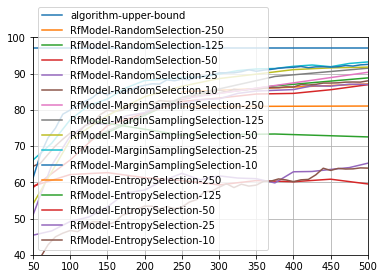

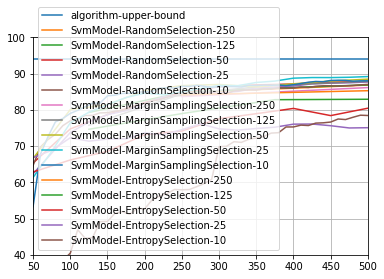

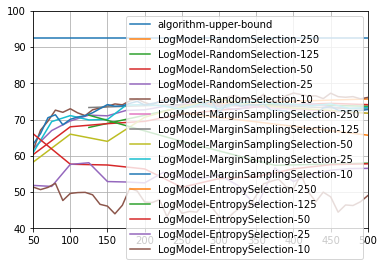

In [ ]:
def performance_plot(fully_supervised_accuracy, dic, models, selection_functions, Ks, repeats):  
    fig, ax = plt.subplots()
    ax.plot([0,500],[fully_supervised_accuracy, fully_supervised_accuracy],label = 'algorithm-upper-bound')
    for model_object in models:
      for selection_function in selection_functions:
        for idx, k in enumerate(Ks):
            x = np.arange(float(Ks[idx]), 500 + float(Ks[idx]), float(Ks[idx]))            
            Sum = np.array(dic[model_object][selection_function][k][0])
            for i in range(1, repeats):
                Sum = Sum + np.array(dic[model_object][selection_function][k][i])
            mean = Sum / repeats
            ax.plot(x, mean ,label = model_object + '-' + selection_function + '-' + str(k))
    ax.legend()
    ax.set_xlim([50,500])
    ax.set_ylim([40,100])
    ax.grid(True)
    plt.show()

models_str = ['SvmModel', 'RfModel', 'LogModel']
selection_functions_str = ['RandomSelection', 'MarginSamplingSelection', 'EntropySelection']
Ks_str = ['250','125','50','25','10'] 
repeats = 1
random_forest_upper_bound = 97.
svm_upper_bound = 94.
log_upper_bound = 92.47
total_experiments = len(models_str) * len(selection_functions_str) * len(Ks_str) * repeats

print('So which is the better model? under the stopping condition and hyper parameters - random forest is the winner!')
performance_plot(random_forest_upper_bound, d, ['RfModel'] , selection_functions_str    , Ks_str, 1)
performance_plot(svm_upper_bound, d, ['SvmModel'] , selection_functions_str    , Ks_str, 1)
performance_plot(log_upper_bound, d, ['LogModel'] , selection_functions_str    , Ks_str, 1)



So which is the best sample selection function? margin sampling is the winner!


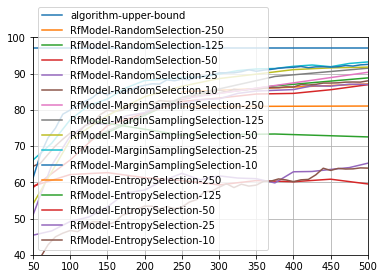


So which is the best k? k=10 is the winner


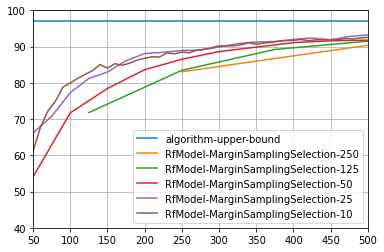

In [ ]:

print('So which is the best sample selection function? margin sampling is the winner!')
performance_plot(random_forest_upper_bound, d, ['RfModel'], selection_functions_str    , Ks_str, 1)
print()
print('So which is the best k? k=10 is the winner')
performance_plot(random_forest_upper_bound, d, ['RfModel'] , ['MarginSamplingSelection'], Ks_str, 1)


I would like to thank Moshe Hadad for his valueable critique regarding PEP8 and Shay Zweig for his proof-reading and comments.

Ori Cohen has done his PhD in computer science in the fields of machine learning, brain-computer-interface and neurobiology.

[1] Shay Yehezkel, *High Dimensional Statistical Process Control and Application*, M.Sc Thesis.

[2] Ilhan, Hamza Osman, and Mehmet Fatih Amasyali. "[*Active Learning as a Way of Increasing Accuracy*](http://www.ijcte.org/papers/910-AC0013.pdf)." International Journal of Computer Theory and Engineering 6, no. 6 (2014): 460.

[3] Stefan Hosein [*Active Learning: Curious AI Algorithms*](https://www.datacamp.com/community/tutorials/active-learning)


In [ ]:
#@title Executed code for the experiment with output.
#!/usr/bin/python
# -*- coding: utf-8 -*-
import os
import time
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats
from pylab import rcParams
from sklearn.utils import check_random_state
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, \
    GradientBoostingClassifier

trainset_size = 60000  # ie., testset_size = 10000
max_queried = 500


# ==============================================================================

def download():
    mnist = fetch_mldata('MNIST original')
    X = mnist.data.astype('float64')
    y = mnist.target
    print ('MNIST:', X.shape, y.shape)
    return (X, y)


def split(train_size):
    X_train_full = X[:train_size]
    y_train_full = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    return (X_train_full, y_train_full, X_test, y_test)


# ==============================================================================

class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass


class SvmModel(BaseModel):

    model_type = 'Support Vector Machine with linear Kernel'
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training svm...')
        self.classifier = SVC(C=1, kernel='linear', probability=True,
                              class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)


class GmmModel(BaseModel):

    model_type = 'Gaussian Mixture Model'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training gaussian mixture model...')
        pca = PCA(n_components=75).fit(X_train)  # ,whiten=True).fit(X_train)
        reduced_train_data = pca.transform(X_train)
        reduced_test_data = pca.transform(X_test)
        reduced_val_data = pca.transform(X_val)
        print ('PCA: explained_variance_ratio_',
               np.sum(pca.explained_variance_ratio_))
        self.classifier = GaussianMixture(n_components=10, covariance_type='full')
        self.classifier.fit(reduced_train_data)
        self.test_y_predicted = \
            self.classifier.predict(reduced_test_data)
        self.val_y_predicted = self.classifier.predict(reduced_val_data)
        return (reduced_train_data, reduced_val_data,
                reduced_test_data, self.val_y_predicted,
                self.test_y_predicted)


class LogModel(BaseModel):

    model_type = 'Multinominal Logistic Regression' 
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training multinomial logistic regression')
        train_samples = X_train.shape[0]
        self.classifier = LogisticRegression(
            C=50. / train_samples,
            multi_class='multinomial',
            penalty='l1',
            solver='saga',
            tol=0.1,
            class_weight=c_weight,
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)


class GbcModel(BaseModel):

    model_type = 'Gradient Boosting Classifier'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training gradient boosting...')
        parm = {
            'n_estimators': 1200,
            'max_depth': 3,
            'subsample': 0.5,
            'learning_rate': 0.01,
            'min_samples_leaf': 1,
            'random_state': 3,
            }
        self.classifier = GradientBoostingClassifier(**parm)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)


class RfModel(BaseModel):

    model_type = 'Random Forest'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training random forest...')
        self.classifier = RandomForestClassifier(n_estimators=500, class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)


# ====================================================================================================

class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    # we train normally and get probabilities for the validation set. i.e., we use the probabilities to select the most uncertain samples

    def train(self, X_train, y_train, X_val, X_test, c_weight):
        print ('Train set:', X_train.shape, 'y:', y_train.shape)
        print ('Val   set:', X_val.shape)
        print ('Test  set:', X_test.shape)
        t0 = time.time()
        (X_train, X_val, X_test, self.val_y_predicted,
         self.test_y_predicted) = \
            self.model_object.fit_predict(X_train, y_train, X_val, X_test, c_weight)
        self.run_time = time.time() - t0
        return (X_train, X_val, X_test)  # we return them in case we use PCA, with all the other algorithms, this is not needed.

    # we want accuracy only for the test set

    def get_test_accuracy(self, i, y_test):
        classif_rate = np.mean(self.test_y_predicted.ravel() == y_test.ravel()) * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:',i)
        print('--------------------------------')
        print('y-test set:',y_test.shape)
        print('Example run in %.3f s' % self.run_time,'\n')
        print("Accuracy rate for %f " % (classif_rate))    
        print("Classification report for classifier %s:\n%s\n" % (self.model_object.classifier, metrics.classification_report(y_test, self.test_y_predicted)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, self.test_y_predicted))
        print('--------------------------------')


# ====================================================================================================

def get_k_random_samples(initial_labeled_samples, X_train_full,
                         y_train_full):
    random_state = check_random_state(0)
    permutation = np.random.choice(trainset_size,
                                   initial_labeled_samples,
                                   replace=False)
    print ()
    print ('initial random chosen samples', permutation.shape),
#            permutation)
    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    X_train = X_train.reshape((X_train.shape[0], -1))
    bin_count = np.bincount(y_train.astype('int64'))
    unique = np.unique(y_train.astype('int64'))
    print (
        'initial train set:',
        X_train.shape,
        y_train.shape,
        'unique(labels):',
        bin_count,
        unique,
        )
    return (permutation, X_train, y_train)


# ====================================================================================================

class BaseSelectionFunction(object):

    def __init__(self):
        pass

    def select(self):
        pass


class RandomSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        random_state = check_random_state(0)
        selection = np.random.choice(probas_val.shape[0], initial_labeled_samples, replace=False)

#     print('uniques chosen:',np.unique(selection).shape[0],'<= should be equal to:',initial_labeled_samples)

        return selection


class MinStdSelection(BaseSelectionFunction):

    # select the samples where the std is smallest - i.e., there is uncertainty regarding the relevant class
    # and then train on these "hard" to classify samples.

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        std = np.std(probas_val * 100, axis=1)
        selection = std.argsort()[:initial_labeled_samples]
        selection = selection.astype('int64')

#     print('std',std.shape,std)
#     print()
#     print('selection',selection, selection.shape, std[selection])

        return selection


class MarginSamplingSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        rev = np.sort(probas_val, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        selection = np.argsort(values)[:initial_labeled_samples]
        return selection


class EntropySelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        e = (-probas_val * np.log2(probas_val)).sum(axis=1)
        selection = (np.argsort(e)[::-1])[:initial_labeled_samples]
        return selection


# ====================================================================================================

class Normalize(object):
    
    def normalize(self, X_train, X_val, X_test):
        self.scaler = MinMaxScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_val, X_test) 
    
    def inverse(self, X_train, X_val, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_val   = self.scaler.inverse_transform(X_val)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_val, X_test) 

      
# ====================================================================================================

class TheAlgorithm(object):

    accuracies = []

    def __init__(self, initial_labeled_samples, model_object, selection_function):
        self.initial_labeled_samples = initial_labeled_samples
        self.model_object = model_object
        self.sample_selection_function = selection_function

    def run(self, X_train_full, y_train_full, X_test, y_test):

        # initialize process by applying base learner to labeled training data set to obtain Classifier

        (permutation, X_train, y_train) = \
            get_k_random_samples(self.initial_labeled_samples,
                                 X_train_full, y_train_full)
        self.queried = self.initial_labeled_samples
        self.samplecount = [self.initial_labeled_samples]

        # permutation, X_train, y_train = get_equally_k_random_samples(self.initial_labeled_samples,classes)

        # assign the val set the rest of the 'unlabelled' training data

        X_val = np.array([])
        y_val = np.array([])
        X_val = np.copy(X_train_full)
        X_val = np.delete(X_val, permutation, axis=0)
        y_val = np.copy(y_train_full)
        y_val = np.delete(y_val, permutation, axis=0)
        print ('val set:', X_val.shape, y_val.shape, permutation.shape)
        print ()

        # normalize data

        normalizer = Normalize()
        X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)   
        
        self.clf_model = TrainModel(self.model_object)
        (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
        active_iteration = 1
        self.clf_model.get_test_accuracy(1, y_test)

        # fpfn = self.clf_model.test_y_predicted.ravel() != y_val.ravel()
        # print(fpfn)
        # self.fpfncount = []
        # self.fpfncount.append(fpfn.sum() / y_test.shape[0] * 100)

        while self.queried < max_queried:

            active_iteration += 1

            # get validation probabilities

            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_val)
            print ('val predicted:',
                   self.clf_model.val_y_predicted.shape,
                   self.clf_model.val_y_predicted)
            print ('probabilities:', probas_val.shape, '\n',
                   np.argmax(probas_val, axis=1))

            # select samples using a selection function

            uncertain_samples = \
                self.sample_selection_function.select(probas_val, self.initial_labeled_samples)

            # normalization needs to be inversed and recalculated based on the new train and test set.
 
            X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   

            # get the uncertain samples from the validation set

            print ('trainset before', X_train.shape, y_train.shape)
            X_train = np.concatenate((X_train, X_val[uncertain_samples]))
            y_train = np.concatenate((y_train, y_val[uncertain_samples]))
            print ('trainset after', X_train.shape, y_train.shape)
            self.samplecount.append(X_train.shape[0])

            bin_count = np.bincount(y_train.astype('int64'))
            unique = np.unique(y_train.astype('int64'))
            print (
                'updated train set:',
                X_train.shape,
                y_train.shape,
                'unique(labels):',
                bin_count,
                unique,
                )

            X_val = np.delete(X_val, uncertain_samples, axis=0)
            y_val = np.delete(y_val, uncertain_samples, axis=0)
            print ('val set:', X_val.shape, y_val.shape)
            print ()

            # normalize again after creating the 'new' train/test sets
            normalizer = Normalize()
            X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)               

            self.queried += self.initial_labeled_samples
            (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
            self.clf_model.get_test_accuracy(active_iteration, y_test)

        print ('final active learning accuracies',
               self.clf_model.accuracies)


# get MNIST

(X, y) = download()
(X_train_full, y_train_full, X_test, y_test) = split(trainset_size)
print ('train:', X_train_full.shape, y_train_full.shape)
print ('test :', X_test.shape, y_test.shape)
classes = len(np.unique(y))
print ('unique classes', classes)

def pickle_save(fname, data):
  filehandler = open(fname,"wb")
  pickle.dump(data,filehandler)
  filehandler.close() 
  print('saved', fname, os.getcwd(), os.listdir())

def experiment(d, models, selection_functions, Ks, repeats, contfrom):
    algos_temp = []
    print ('stopping at:', max_queried)
    count = 0
    for model_object in models:
      if model_object.__name__ not in d:
          d[model_object.__name__] = {}
      
      for selection_function in selection_functions:
        if selection_function.__name__ not in d[model_object.__name__]:
            d[model_object.__name__][selection_function.__name__] = {}
        
        for k in Ks:
            d[model_object.__name__][selection_function.__name__][k] = []           
            
            for i in range(0, repeats):
                count+=1
                if count >= contfrom:
                    print ('Count = %s, using model = %s, selection_function = %s, k = %s, iteration = %s.' % (count, model_object.__name__, selection_function.__name__, k, i))
                    alg = TheAlgorithm(k, 
                                       model_object, 
                                       selection_function
                                       )
                    alg.run(X_train_full, y_train_full, X_test, y_test)
                    d[model_object.__name__][selection_function.__name__][k].append(alg.clf_model.accuracies)
                    fname = 'Active-learning-experiment-' + str(count) + '.pkl'
                    pickle_save(fname, d)
                    if count % 5 == 0:
                        print(json.dumps(d, indent=2, sort_keys=True))
                    print ()
                    print ('---------------------------- FINISHED ---------------------------')
                    print ()
    return d

max_queried = 500
# max_queried = 20

repeats = 1

models = [SvmModel, RfModel, LogModel]#, GbcModel]
# models = [RfModel, SvmModel]

selection_functions = [RandomSelection, MarginSamplingSelection, EntropySelection]#, MinStdSelection]
# selection_functions = [MarginSamplingSelection]

Ks = [250,125,50,25,10]
# Ks = [10]

d = {}
stopped_at = -1

# stopped_at = 73
# d = pickle_load('Active-learning-experiment-'+ str(stopped_at) +'.pkl')  
# print(json.dumps(d, indent=2, sort_keys=True))

d = experiment(d, models, selection_functions, Ks, repeats, stopped_at+1)
print(json.dumps(d, indent=2, sort_keys=True))



ImportError: ignored

In [ ]:
#@title Manual assignment of the dictionary json dump to a variable, these are the results from the previous cell.

d = {
  "LogModel": {
    "EntropySelection": {
      "10": [
        [
          36.620000000000005,
          46.79,
          47.49,
          49.96,
          51.59,
          54.25,
          49.43,
          55.510000000000005,
          52.88,
          50.89,
          53.04,
          52.42,
          52.410000000000004,
          50.949999999999996,
          48.699999999999996,
          48.89,
          51.160000000000004,
          47.68,
          46.1,
          48.91,
          50.739999999999995,
          53.080000000000005,
          54.790000000000006,
          50.88,
          53.790000000000006,
          56.05,
          54.06999999999999,
          57.85,
          54.279999999999994,
          55.86,
          57.43000000000001,
          47.57,
          53.480000000000004,
          55.21,
          53.32,
          54.98,
          52.51,
          54.39000000000001,
          55.88999999999999,
          54.61,
          55.69,
          54.510000000000005,
          52.559999999999995,
          53.66,
          56.089999999999996,
          54.230000000000004,
          51.77,
          52.629999999999995,
          55.00000000000001,
          48.97
        ]
      ],
      "25": [
        [
          59.050000000000004,
          52.849999999999994,
          54.71,
          55.16,
          52.349999999999994,
          53.94,
          53.43,
          51.480000000000004,
          45.94,
          48.92,
          48.55,
          44.51,
          50.72,
          48.29,
          49.69,
          53.61,
          49.91,
          50.12,
          50.59,
          52.66
        ]
      ],
      "50": [
        [
          61.82,
          60.31999999999999,
          54.03,
          57.220000000000006,
          58.67,
          57.11000000000001,
          53.18000000000001,
          57.76,
          55.08,
          53.42
        ]
      ],
      "125": [
        [
          69.07,
          62.660000000000004,
          58.93000000000001,
          60.5
        ]
      ],
      "250": [
        [
          73.77,
          63.23
        ]
      ]
    },
    "MarginSamplingSelection": {
      "10": [
        [
          33.269999999999996,
          56.63,
          57.709999999999994,
          61.82,
          64.57000000000001,
          67.43,
          69.24,
          69.76,
          69.87,
          71.05,
          73.27,
          71.35000000000001,
          70.75,
          72.61,
          71.23,
          72.57000000000001,
          72.38,
          73.17,
          73.94,
          73.44000000000001,
          72.26,
          72.78,
          73.68,
          72.75,
          73.79,
          73.91,
          72.39,
          71.72,
          74.39,
          73.09,
          73.39,
          73.25,
          72.8,
          74.51,
          72.15,
          72.08,
          71.78,
          73.69,
          73.19,
          73.00999999999999,
          72.68,
          71.67,
          72.71,
          74.11,
          73.06,
          74.33999999999999,
          72.56,
          72.64,
          72.35000000000001,
          72.86
        ]
      ],
      "25": [
        [
          41.980000000000004,
          52.12,
          65.4,
          64.84,
          65.10000000000001,
          64.14,
          65.86999999999999,
          66.99000000000001,
          70.11,
          70.44,
          67.21000000000001,
          71.17,
          70.33,
          70.12,
          71.6,
          70.3,
          68.16,
          69.51,
          69.59,
          70.85000000000001
        ]
      ],
      "50": [
        [
          62.8,
          70.19,
          68.39,
          71.65,
          69.44,
          70.94,
          70.7,
          70.14,
          71.17,
          70.21
        ]
      ],
      "125": [
        [
          71.11,
          72.42,
          72.0,
          72.81
        ]
      ],
      "250": [
        [
          73.76,
          73.76
        ]
      ]
    },
    "RandomSelection": {
      "10": [
        [
          31.61,
          50.36000000000001,
          53.1,
          59.74,
          62.7,
          64.03999999999999,
          64.25,
          61.629999999999995,
          66.47,
          68.0,
          65.75999999999999,
          65.0,
          65.27,
          66.46,
          66.99000000000001,
          66.86,
          67.28,
          66.72,
          67.10000000000001,
          68.33,
          69.25,
          69.69999999999999,
          69.32000000000001,
          67.72,
          69.87,
          68.69,
          68.83,
          70.00999999999999,
          69.65,
          70.19,
          71.41,
          70.53,
          70.15,
          68.74,
          70.0,
          68.24,
          68.92,
          67.91,
          69.17999999999999,
          68.87,
          69.02000000000001,
          70.00999999999999,
          70.47,
          71.83,
          70.78,
          70.61,
          71.33,
          70.91,
          71.0,
          71.78999999999999
        ]
      ],
      "25": [
        [
          46.63,
          57.86,
          62.019999999999996,
          70.61,
          72.74000000000001,
          69.82000000000001,
          69.6,
          70.81,
          70.82000000000001,
          69.49,
          71.46000000000001,
          71.48,
          72.04,
          72.11,
          72.65,
          73.09,
          73.72,
          73.86,
          74.69,
          73.72999999999999
        ]
      ],
      "50": [
        [
          68.38,
          66.14999999999999,
          70.45,
          72.68,
          72.31,
          72.33000000000001,
          73.44000000000001,
          71.78999999999999,
          73.11999999999999,
          70.84
        ]
      ],
      "125": [
        [
          68.95,
          68.53,
          71.67,
          73.09
        ]
      ],
      "250": [
        [
          73.11,
          74.56
        ]
      ]
    }
  },
  "RfModel": {
    "EntropySelection": {
      "10": [
        [
          37.519999999999996,
          42.53,
          51.42,
          49.03,
          49.25,
          52.01,
          51.41,
          51.89,
          53.04,
          55.48,
          56.989999999999995,
          56.720000000000006,
          56.93,
          55.169999999999995,
          56.26,
          55.64,
          54.769999999999996,
          54.98,
          54.06999999999999,
          53.71,
          53.21,
          52.800000000000004,
          53.54,
          52.72,
          52.65,
          51.849999999999994,
          51.67,
          51.89,
          52.54,
          53.03,
          56.06,
          56.26,
          55.669999999999995,
          60.17,
          60.480000000000004,
          59.9,
          58.97,
          60.019999999999996,
          59.81999999999999,
          59.86,
          59.95,
          62.970000000000006,
          63.7,
          62.94,
          62.19,
          62.019999999999996,
          63.89,
          62.150000000000006,
          60.17,
          62.39
        ]
      ],
      "25": [
        [
          44.21,
          39.2,
          37.57,
          35.82,
          36.120000000000005,
          33.64,
          32.09,
          32.1,
          32.28,
          30.759999999999998,
          31.230000000000004,
          29.34,
          26.419999999999998,
          27.05,
          26.58,
          23.23,
          24.0,
          23.7,
          21.58,
          23.84
        ]
      ],
      "50": [
        [
          63.85999999999999,
          60.309999999999995,
          59.760000000000005,
          59.89,
          59.160000000000004,
          59.519999999999996,
          57.9,
          59.74,
          57.06,
          59.91
        ]
      ],
      "125": [
        [
          75.02,
          74.36,
          72.39999999999999,
          72.08
        ]
      ],
      "250": [
        [
          84.39999999999999,
          81.82000000000001
        ]
      ]
    },
    "MarginSamplingSelection": {
      "10": [
        [
          25.72,
          38.83,
          53.99,
          57.53,
          62.39,
          66.58,
          64.23,
          67.5,
          72.75,
          76.35,
          77.31,
          77.96,
          78.17,
          80.67,
          81.76,
          83.63000000000001,
          85.26,
          85.37,
          85.82,
          85.76,
          86.00999999999999,
          87.01,
          87.45,
          87.83,
          88.64999999999999,
          88.1,
          87.92999999999999,
          89.21,
          89.57000000000001,
          90.34,
          91.12,
          90.86,
          91.17,
          91.53999999999999,
          91.84,
          91.75999999999999,
          91.07,
          91.36,
          91.22,
          91.88,
          92.0,
          91.97,
          91.7,
          92.12,
          92.28,
          92.57,
          92.63,
          92.55,
          92.80000000000001,
          92.75999999999999
        ]
      ],
      "25": [
        [
          39.050000000000004,
          51.85999999999999,
          67.30000000000001,
          74.29,
          74.42999999999999,
          80.15,
          83.55,
          83.58,
          86.24000000000001,
          87.22999999999999,
          87.89,
          88.42999999999999,
          88.94,
          90.06,
          89.57000000000001,
          90.03999999999999,
          90.03999999999999,
          91.14,
          91.86,
          91.79
        ]
      ],
      "50": [
        [
          62.99,
          75.07000000000001,
          75.38,
          83.96000000000001,
          87.89,
          89.62,
          89.7,
          91.47999999999999,
          91.84,
          92.49000000000001
        ]
      ],
      "125": [
        [
          76.4,
          85.66,
          90.22,
          92.13
        ]
      ],
      "250": [
        [
          81.26,
          87.98
        ]
      ]
    },
    "RandomSelection": {
      "10": [
        [
          36.01,
          43.34,
          53.94,
          58.02,
          60.97,
          66.44,
          68.63,
          70.8,
          72.08,
          73.58,
          73.63,
          74.0,
          74.2,
          75.52,
          75.41,
          75.81,
          75.98,
          77.97,
          77.5,
          80.15,
          79.81,
          81.13,
          80.87,
          80.58999999999999,
          80.86,
          81.26,
          82.26,
          82.44,
          82.75,
          82.92,
          83.76,
          83.50999999999999,
          85.05,
          85.50999999999999,
          85.13,
          86.02,
          86.02,
          86.5,
          86.09,
          85.83,
          86.9,
          86.46000000000001,
          86.38,
          86.88,
          87.09,
          87.87,
          87.47,
          87.59,
          87.74,
          87.78
        ]
      ],
      "25": [
        [
          51.64,
          60.72,
          65.45,
          70.28999999999999,
          72.94,
          76.08,
          77.51,
          77.78,
          79.35,
          80.39,
          81.6,
          81.17,
          82.73,
          84.28,
          84.15,
          85.2,
          86.13,
          86.78,
          86.95,
          87.59
        ]
      ],
      "50": [
        [
          56.86,
          69.43,
          71.87,
          75.68,
          80.01,
          82.06,
          84.5,
          85.92,
          86.76,
          87.32
        ]
      ],
      "125": [
        [
          71.5,
          82.39,
          85.76,
          87.56
        ]
      ],
      "250": [
        [
          83.19,
          88.14999999999999
        ]
      ]
    }
  },
  "SvmModel": {
    "EntropySelection": {
      "10": [
        [
          35.93,
          35.97,
          40.33,
          39.39,
          41.349999999999994,
          42.99,
          46.23,
          46.18,
          47.260000000000005,
          52.5,
          52.400000000000006,
          51.25999999999999,
          51.690000000000005,
          51.800000000000004,
          53.18000000000001,
          53.82,
          55.88999999999999,
          56.120000000000005,
          57.269999999999996,
          59.41,
          59.95,
          62.629999999999995,
          61.339999999999996,
          63.88,
          65.34,
          65.77,
          66.9,
          67.96,
          68.27,
          67.44,
          68.45,
          68.63,
          68.0,
          68.47,
          68.77,
          68.8,
          69.17,
          68.97,
          69.33,
          69.67999999999999,
          69.95,
          70.34,
          70.47,
          71.19,
          71.97,
          72.26,
          72.06,
          71.98,
          72.55,
          72.78999999999999
        ]
      ],
      "25": [
        [
          50.33,
          51.59,
          56.599999999999994,
          60.24,
          61.57,
          63.5,
          66.74,
          68.19,
          68.02,
          69.8,
          75.88000000000001,
          77.24,
          78.09,
          79.38,
          80.4,
          80.99,
          80.28999999999999,
          80.12,
          79.75999999999999,
          80.36999999999999
        ]
      ],
      "50": [
        [
          64.55,
          68.75,
          71.34,
          74.11999999999999,
          75.96000000000001,
          77.03999999999999,
          76.85,
          79.19,
          80.51,
          80.99
        ]
      ],
      "125": [
        [
          78.4,
          78.21000000000001,
          80.08,
          81.0
        ]
      ],
      "250": [
        [
          83.11,
          84.53
        ]
      ]
    },
    "MarginSamplingSelection": {
      "10": [
        [
          31.86,
          37.6,
          46.23,
          58.41,
          60.34,
          65.98,
          65.01,
          69.86,
          72.28999999999999,
          74.65,
          76.24,
          77.37,
          77.59,
          78.7,
          79.06,
          80.06,
          81.21000000000001,
          82.32000000000001,
          83.17,
          83.78,
          84.6,
          84.58,
          84.47,
          85.07000000000001,
          85.64,
          85.75,
          85.7,
          86.18,
          86.58,
          86.50999999999999,
          86.71,
          87.09,
          86.91,
          87.13,
          87.42999999999999,
          87.75,
          87.97,
          88.23,
          88.23,
          88.22,
          88.16000000000001,
          88.03,
          88.38000000000001,
          88.39,
          88.64,
          88.98,
          89.05999999999999,
          89.34,
          89.3,
          89.52
        ]
      ],
      "25": [
        [
          50.160000000000004,
          63.73,
          70.14,
          74.4,
          78.99000000000001,
          80.36999999999999,
          82.76,
          84.35000000000001,
          85.78,
          86.61999999999999,
          87.46000000000001,
          87.64,
          88.08,
          88.75,
          88.68,
          89.02,
          89.39,
          89.57000000000001,
          89.66,
          89.8
        ]
      ],
      "50": [
        [
          59.099999999999994,
          69.91000000000001,
          75.66000000000001,
          81.41000000000001,
          82.69,
          85.07000000000001,
          85.92,
          86.89,
          87.8,
          87.6
        ]
      ],
      "125": [
        [
          79.45,
          84.1,
          86.36,
          88.16000000000001
        ]
      ],
      "250": [
        [
          84.58,
          87.38
        ]
      ]
    },
    "RandomSelection": {
      "10": [
        [
          31.009999999999998,
          33.54,
          48.67,
          57.34,
          61.68,
          64.75999999999999,
          69.28,
          71.97,
          73.2,
          74.03,
          75.08,
          76.01,
          76.55,
          77.42999999999999,
          77.75,
          79.72,
          80.78,
          81.62,
          81.8,
          82.03,
          81.82000000000001,
          82.72,
          82.94,
          83.03,
          83.72,
          83.81,
          83.72,
          83.95,
          84.38,
          85.02,
          85.36,
          85.65,
          85.26,
          85.37,
          85.37,
          85.19,
          85.18,
          85.61999999999999,
          85.47,
          85.61999999999999,
          85.78,
          86.00999999999999,
          86.05000000000001,
          85.96000000000001,
          85.96000000000001,
          86.0,
          86.24000000000001,
          86.6,
          86.66,
          86.81
        ]
      ],
      "25": [
        [
          51.449999999999996,
          67.88,
          72.25,
          77.82,
          79.19,
          80.32000000000001,
          81.19,
          81.91000000000001,
          82.67999999999999,
          82.89,
          82.89,
          83.05,
          83.91999999999999,
          84.69,
          84.77,
          84.66,
          85.0,
          85.3,
          85.79,
          86.08
        ]
      ],
      "50": [
        [
          56.38999999999999,
          72.92999999999999,
          78.44,
          81.0,
          82.73,
          83.52000000000001,
          84.35000000000001,
          85.17,
          86.17,
          86.66
        ]
      ],
      "125": [
        [
          73.76,
          83.52000000000001,
          85.6,
          86.44
        ]
      ],
      "250": [
        [
          83.02000000000001,
          85.64
        ]
      ]
    }
  }
}